In [97]:
import tsfresh as tsf
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns

from importlib import reload
from itertools import product
from datetime import timedelta
from scipy import signal
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from tsfresh.utilities.distribution import ClusterDaskDistributor
from src import main, feature_model, extract_tsf_features_by_window as extract
from dask_jobqueue import SLURMCluster
from distributed import Client, as_completed

# Extract features from data

In [70]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=2, memory='4gb', walltime='3:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=100)

In [71]:
client

Client Scheduler: tcp://10.120.16.229:37531 Dashboard: http://10.120.16.229:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [72]:
cis_colnames = {'t_colname': 'Timestamp', 'xyz_colnames': ['X', 'Y', 'Z']}
smartwatch_colnames = {'devid_colnames': ['device_id']}

In [232]:
def extract_fft_features(input_fp, 
                         window_offset=5, 
                         window_size=10, 
                         samp_rate='100ms',
                         rms_g_constant=1,
                         colnames=dict()):
    def fftvec(seq):
        spec = np.fft.fft(seq)
        freqs = np.fft.fftfreq(n=spec.shape[0], d=pd.to_timedelta(samp_rate).total_seconds())
        s = pd.DataFrame(data=spec.real, index=np.round(freqs, decimals=1))
        return s[s.index > 0].T
    
    seq = main.read_seq(input_fp, use_time_index=True, resample=samp_rate, **colnames)
    # some slight interpolation for missing values
    seq = seq.interpolate(axis=0, limit=1, method='linear')
    
    # subtract constant for gravity
    rms = pd.DataFrame({'rms': np.sqrt(np.square(seq).sum(axis=1, skipna=False)) - rms_g_constant})
    
    window_starts = [pd.Timedelta(seconds=t) for t in [*range(0, rms.index.get_level_values('t').max().seconds - window_size, window_offset)]]
    samples = main.sample_seq(rms, starts=window_starts, samp_len=pd.Timedelta(seconds=window_size), reset_time=True)
    for i, df in enumerate(samples):
        df['ord'] = str(i)
        if 'devid_colnames' in colnames:
            df.reset_index(level=colnames['devid_colnames'], inplace=True)
            df['ord'] += '-' + df[colnames['devid_colnames'][0]]
            df.drop(columns=colnames['devid_colnames'], inplace=True)
    
    # remove windows with nulls
    data = pd.concat(samples, axis=0).groupby('ord').filter(lambda x: x.notnull().values.all())

    results = data.groupby('ord').apply(fftvec)
    samp_id = os.path.splitext(os.path.basename(input_fp))[0]
    results['samp_id'] = samp_id

    return results.reset_index(level=1, drop=True)

In [197]:
window_size = 10
window_offset = 5
futures = []

In [233]:
fp = 'data/real-pd/training_data/smartwatch_gyroscope/014ccd5a-7f4a-480b-8ab5-1ed8601d0721.csv'
d = extract_fft_features(fp, colnames=smartwatch_colnames)

In [245]:
# Training data for cis_pd
fps = glob.glob('data/cis-pd/training_data/*.csv')
futures = client.map(extract_fft_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=1, 
                          colnames=cis_colnames)

In [246]:
# Write to disk directly since too much to store in mem
iterator = as_completed(futures)
future = next(iterator)
while future.status == 'error': 
    future = next(iterator)
result = future.result()
result.to_csv('extracted_features/ensem/cis-fftfeatures.csv', header=True, index=True)

# Write remaining dfs in append mode 
for future in tqdm(iterator, total=len(futures)-1):
    if future.status == 'finished':
        result = future.result()
        result.to_csv('extracted_features/ensem/cis-fftfeatures.csv', header=False, mode='a', index=True)

In [247]:
# real_pd smartphone accelerometer
fps = glob.glob('data/real-pd/training_data/smartphone_accelerometer/*.csv')
futures = client.map(extract_fft_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=9.81)

In [248]:
# Write to disk directly since too much to store in mem
iterator = as_completed(futures)
future = next(iterator)
while future.status == 'error': 
    future = next(iterator)
result = future.result()
result.to_csv('extracted_features/ensem/real_phone_accel-fftfeatures.csv', header=True, index=True)

# Write remaining dfs in append mode 
for future in tqdm(iterator, total=len(futures)-1):
    if future.status == 'finished':
        result = future.result()
        result.to_csv('extracted_features/ensem/real_phone_accel-fftfeatures.csv', header=False, mode='a', index=True)

In [235]:
# real_pd smartwatch accelerometer
fps = glob.glob('data/real-pd/training_data/smartwatch_accelerometer/*.csv')
futures = client.map(extract_fft_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=9.81, 
                          colnames=smartwatch_colnames)

In [236]:
# Write to disk directly since too much to store in mem
iterator = as_completed(futures)
future = next(iterator)
while future.status == 'error': 
    future = next(iterator)
result = future.result()
result.to_csv('extracted_features/ensem/real_watch_accel-fftfeatures.csv', header=True, index=True)

# Write remaining dfs in append mode 
for future in tqdm(iterator, total=len(futures)-1):
    if future.status == 'finished':
        result = future.result()
        result.to_csv('extracted_features/ensem/real_watch_accel-fftfeatures.csv', header=False, mode='a', index=True)

In [237]:
# real_pd smartwatch gyroscope
fps = glob.glob('data/real-pd/training_data/smartwatch_gyroscope/*.csv')
futures = client.map(extract_fft_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=0, 
                          colnames=smartwatch_colnames)

In [238]:
# Write to disk directly since too much to store in mem
iterator = as_completed(futures)
future = next(iterator)
while future.status == 'error': 
    future = next(iterator)
result = future.result()
result.to_csv('extracted_features/ensem/real_watch_gyro-fftfeatures.csv', header=True, index=True)

# Write remaining dfs in append mode 
for future in tqdm(iterator, total=len(futures)-1):
    if future.status == 'finished':
        result = future.result()
        result.to_csv('extracted_features/ensem/real_watch_gyro-fftfeatures.csv', header=False, mode='a', index=True)

# PCA on windowed tsfresh features

In [3]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=8, memory='8gb', walltime='1:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=100)

## Yidi's windows

In [240]:
features_df = pd.read_csv('extracted_features/ensem/real_watch_accel-fftfeatures.csv')

In [ ]:
features_df

In [163]:
label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
labels = pd.concat([
    pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'),
    pd.read_csv('/home/hy180/projects/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv'),
], axis=0).astype({'subject_id': str})

In [241]:
df = features_df.dropna().merge(labels, right_on='measurement_id', left_on='samp_id')
print('%d rows dropped due to nans in features' % (features_df.shape[0] - df.shape[0]))

31034 rows dropped due to nans in features


In [254]:
other_cols = ['samp_id', 'measurement_id', 'ord']

In [49]:
df = df.dropna(axis='columns', thresh=500).dropna(axis='rows')

In [255]:
from sklearn import decomposition
import umap

label = 'tremor'
X = df[df.samp_id.isin(df.dropna(subset=[label]).samp_id)].drop(columns=[*label_cols, *other_cols]).dropna(axis='columns')
y = df[df.samp_id.isin(df.dropna(subset=[label]).samp_id)][[*label_cols, *other_cols]]

ca = decomposition.PCA()
# ca = umfap.UMAP(n_components=5)

In [256]:
fut = client.submit(ca.fit_transform, X)

In [257]:
fut

<Future: finished, type: numpy.ndarray, key: fit_transform-e3693929a0eb63802bb15399d08ecff9>

In [258]:
proj = client.gather(fut)

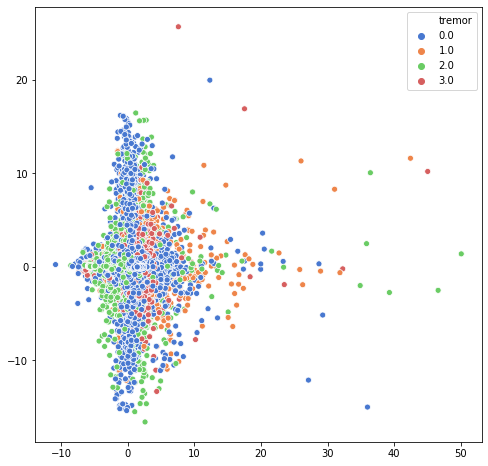

In [260]:
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y.loc[:, 'tremor'], legend='full', palette="muted")

In [96]:
labels[labels.subject_id==1048].on_off.value_counts()

2.0    45
1.0    27
3.0    14
4.0     3
0.0     2
Name: on_off, dtype: int64

In [92]:
labels[labels.tremor==4]

,subject_id,on_off,dyskinesia,tremor
measurement_id,,,,
daf11494-e6fa-4376-a78a-86c683885764,1004,4.0,4.0,4.0
ee389c0c-71dd-47a9-9249-9c1bcd6c4f69,1048,1.0,3.0,4.0
eef56825-940a-4c3e-aebb-60838d60869e,1048,4.0,3.0,4.0
40f713fe-0ac9-4cd0-809c-0a8024955a2a,1048,3.0,3.0,4.0
4913062f-b696-40c6-a0f2-87efe1dd4810,1048,3.0,3.0,4.0
b9ada852-4ff5-4ee1-8529-96a79ced0610,1048,1.0,4.0,4.0
7b2698a6-f3a5-4345-9630-25d377d58992,1048,2.0,3.0,4.0
dd140d80-bcab-458b-bd0e-82cd584d0f28,1048,3.0,3.0,4.0
e0441156-c4b8-467c-8f4f-3b532d594d8f,1048,4.0,3.0,4.0


## Mark's windows

In [ ]:
raise Exception

In [4]:
import glob
import os

In [7]:
def read_samps(fp):
    df = pd.read_csv(fp, index_col=0)
    df = df.rename(columns={'id': 'axis'})    
    df['samp_id'] = os.path.splitext(os.path.splitext(os.path.basename(fp))[0])[0]
    return df[df.axis=='X']

In [8]:
futures = client.map(read_samps, glob.glob('/home/mk596/research/beat_pd/data/cis-pd/training_data_tsf/*.tsf.csv')[:300])

In [17]:
dfs = client.gather(futures)
features = pd.concat(dfs)

In [9]:
dfs = []
for fp in tqdm(glob.glob('/home/mk596/research/beat_pd/data/cis-pd/training_data_tsf/*.tsf.csv')[:300]):
    df = pd.read_csv(fp, index_col=0)
    df = df.rename(columns={'id': 'axis'})    
    df['samp_id'] = os.path.splitext(os.path.splitext(os.path.basename(fp))[0])[0]
    dfs.append(df[df.axis=='X'])
    
features = pd.concat(dfs)